In [1]:
from sympy import Symbol, pi, sin, cos, sinh, cosh, asinh, acosh, im, I
import sympy
from functools import reduce
import operator
from math import sqrt
mul_red = lambda x: reduce(operator.mul, x, 1)

In [2]:
# Following Chebyshev filter implementation from:

# https://en.wikipedia.org/wiki/Chebyshev_filter

In [3]:
s = Symbol("s")
w_0 = 7000 # cutoff freq. LPF
w = Symbol("w")
jw = I * w / w_0
n = 4 # Order
delta = 3 # passband ripple in db
e = sqrt(10**(delta/10) - 1) # ripple factor

In [4]:
def theta(m, n):
    return (pi/2) * ((2*m - 1)/n)

def sp(m, n, e):
    # spm- only not spm+
    return -sinh( (1/n) * asinh(1/e) ) * sin(theta(m, n)) + \
            I * cosh( (1/n) * asinh(1/e)) * cos(theta(m, n))

In [5]:
print("n", n)
Hs = 1/(2**(n-1)) * mul_red([1/(s - sp(m, n, e)) for m in range(1, n+1)])

n 4


In [6]:
Hs

0.125/((s + 0.222560976945829*sqrt(1/2 - sqrt(2)/4) - 1.02446736817679*I*sqrt(sqrt(2)/4 + 1/2))*(s + 0.222560976945829*sin(0.375*pi) - 1.02446736817679*I*cos(0.375*pi))*(s + 0.222560976945829*sin(0.625*pi) - 1.02446736817679*I*cos(0.625*pi))*(s + 0.222560976945829*sin(0.875*pi) - 1.02446736817679*I*cos(0.875*pi)))

In [7]:
G = Hs.subs(s, jw)
G

0.125/((I*w/7000 + 0.222560976945829*sqrt(1/2 - sqrt(2)/4) - 1.02446736817679*I*sqrt(sqrt(2)/4 + 1/2))*(I*w/7000 + 0.222560976945829*sin(0.375*pi) - 1.02446736817679*I*cos(0.375*pi))*(I*w/7000 + 0.222560976945829*sin(0.625*pi) - 1.02446736817679*I*cos(0.625*pi))*(I*w/7000 + 0.222560976945829*sin(0.875*pi) - 1.02446736817679*I*cos(0.875*pi)))

In [8]:
import matplotlib.pyplot as plt
%matplotlib widget

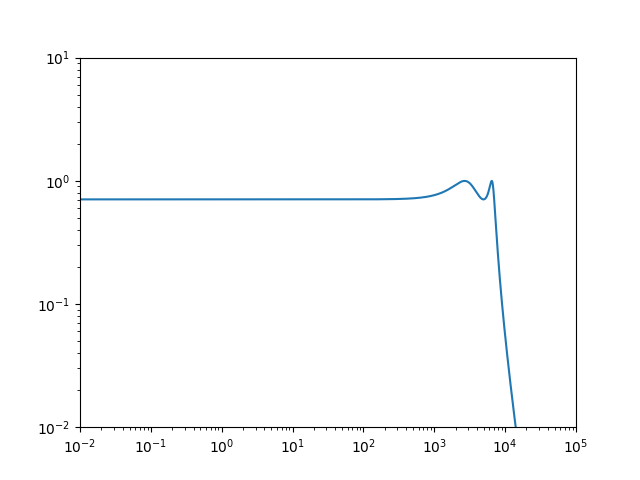

In [9]:
import numpy as np
final_freq = 100_000
a = np.arange(final_freq)
transfer_fn_eval = sympy.lambdify(w, sympy.Abs(G), "numpy")
x_vals = transfer_fn_eval(a)
# x_vals = [sympy.Abs(G.subs(w, a)) for a in range(100_000)]
plt.plot(a, x_vals)
plt.axis([0.01, final_freq, 0.01, 10])
plt.xscale("log")
plt.yscale("log")
plt.show()

In [10]:
# Bandpass transformation
w0 = Symbol("w_0") # Centre frequency
w1 = Symbol("w_1") # Low edge frequency
w2 = Symbol("w_2") # High edge frequency
jw = I * w
w_prime = (w0/(w2-w1))*( (w/w0) - (w0/w) )

# bandpass_fn = Hs.subs(s, jw).subs(w, w_prime)
# Keep everything in the s domain
bandpass_fn = Hs.subs(s, w_prime).subs(w, s) 
bandpass_fn.simplify(trig=True)

0.125*s**4*(w_1 - w_2)**4/((s**2 + s*(w_1 - w_2)*(-0.111280488472914*sqrt(2 - sqrt(2)) + 0.512233684088396*I*sqrt(sqrt(2) + 2)) - w_0**2)*(s**2 + s*(w_1 - w_2)*(-0.111280488472914*sqrt(sqrt(2) + 2) + 0.512233684088396*I*sqrt(2 - sqrt(2))) - w_0**2)*(s**2 + s*(w_1 - w_2)*(-0.222560976945829*sin(0.625*pi) + 1.02446736817679*I*cos(0.625*pi)) - w_0**2)*(s**2 + s*(w_1 - w_2)*(-0.222560976945829*sin(0.875*pi) + 1.02446736817679*I*cos(0.875*pi)) - w_0**2))

In [11]:
low_edge_freq = 70
centre_freq = 700
high_edge_freq = 7000
bandpass_tf = bandpass_fn.subs({w0: centre_freq, 
                                w1: low_edge_freq, 
                                w2: high_edge_freq}
                              )
bandpass_tf = bandpass_tf.simplify()
bandpass_tf

288298877501250.0*s**4/((s*(s + 771.173785117296*sqrt(2 - sqrt(2)) - 3549.77943073258*I*sqrt(sqrt(2) + 2)) - 490000)*(s*(s + 771.173785117296*sqrt(sqrt(2) + 2) - 3549.77943073258*I*sqrt(2 - sqrt(2))) - 490000)*(s*(s + 1542.34757023459*sin(0.625*pi) - 7099.55886146517*I*cos(0.625*pi)) - 490000)*(s*(s + 1542.34757023459*sin(0.875*pi) - 7099.55886146517*I*cos(0.875*pi)) - 490000))

In [12]:
numerator, denominator = bandpass_tf.as_numer_denom()
numerator = sympy.Poly(numerator, s).all_coeffs()
denominator = sympy.Poly(denominator, s).all_coeffs()

# from scipy import signal
# signal.TransferFunction(numerator, denominator)

print("Numerator")
[print(_.evalf()) for _ in numerator]
print("Denominator")
[print(_.evalf()) for _ in denominator]

Numerator
288298877501250.
0
0
0
0
Denominator
1.00000000000000
4030.34842847117 + 0.e-16*I
54186754.22744 + 0.e-13*I
128787244104.224 + 1.8e-6*I
354617881536349.0 - 0.00967*I
-6.31057496110698e+16 + 2.77*I
1.30102396900083e+19 + 0.e-3*I
-4.74166462261204e+20 + 0.e+1*I
5.76480100000000e+22


[None, None, None, None, None, None, None, None, None]

[5.00102046e-21 5.00470674e-21 5.00839574e-21 ... 2.90060489e-06
 2.89846347e-06 2.89632363e-06]


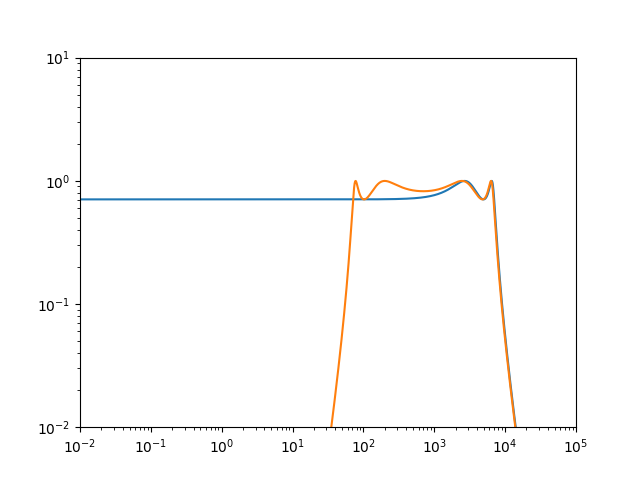

In [13]:
final_freq = 100_000.0
a = np.geomspace(0.001, final_freq, num=100_000, dtype=np.float64)
transfer_fn_eval = sympy.lambdify(w, sympy.Abs(bandpass_tf.subs(s, jw)), "numpy")
y_vals = transfer_fn_eval(a)
print(y_vals)

plt.plot(a, y_vals)
plt.axis([0.01, final_freq, 0.01, 10])
plt.xscale("log")
plt.yscale("log")
plt.show()

In [14]:
# Lets move to the Z domain to keep things clear
z = Symbol("z")
T = Symbol("T")
timestep = 0.000001
# Lets use the tustin approximation!
# I'm literally a 375 and 481 god

f_tustin = (2/T)*( (z-1)/(z+1) )

numerator, denominator = bandpass_tf.subs(s, f_tustin).simplify().as_numer_denom()
numerator = numerator.expand()
denominator = denominator.expand()

In [15]:
num_deg = (sympy.Poly(numerator).degree())
den_deg = (sympy.Poly(denominator).degree())
max_deg = max(num_deg, den_deg)

num_coeffs = sympy.Poly(  numerator.subs(T, timestep), z).all_coeffs()
den_coeffs = sympy.Poly(denominator.subs(T, timestep), z).all_coeffs()

numerator = numerator/ (z**(max_deg))
denominator = denominator/ (z**(max_deg))


In [16]:
# print(bandpass_tf.subs(s, f_tustin).simplify().expand())
print(numerator.expand())


print([_.evalf() for _ in num_coeffs])
print([_.evalf() for _ in den_coeffs])

288298877501250.0*T**4 - 1.153195510005e+15*T**4/z**2 + 1.7297932650075e+15*T**4/z**4 - 1.153195510005e+15*T**4/z**6 + 288298877501250.0*T**4/z**8
[2.88298877501250e-10, 0, -1.15319551000500e-9, 0, 1.72979326500750e-9, 0, -1.15319551000500e-9, 0, 2.88298877501250e-10]
[16.0324597923738 - 0.e-23*I, -128.194324227783 - 0.e-23*I, 448.452265495489 + 0.e-23*I, -896.450530490474 + 0.e-22*I, 1119.99783253196 - 9.50649e-18*I, -895.547735533391 - 0.e-22*I, 447.549468477809 - 0.e-23*I, -127.807409748352 + 0.e-23*I, 15.9679737023693 + 0.e-23*I]


In [17]:
from pydub import AudioSegment
import pydub 

silence = AudioSegment.silent(duration=10000)
silence.export("derp.mp3", format='mp3')
sound = AudioSegment.from_file("derp.mp3", format="mp3")


# sound = AudioSegment.from_file("take_on_me.mp3", format="mp3")

# sound._data is a bytestring
raw_data = sound._data


c:\users\klans\appdata\local\programs\python\python39\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


FileNotFoundError: [WinError 2] The system cannot find the file specified

In [ ]:
raw_data[0:100]

In [ ]:
from scipy import signal


In [ ]:
val = G.subs(w, 1)
print(val)
sympy.Abs(val)